<a href="https://colab.research.google.com/github/ajzh2222-cmd/UAS_DEEP-LEARNING_KELOMPOK/blob/main/UAS_DEEP_LEARNING_KELOMPOK.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, regularizers
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import os
import io
import warnings
warnings.filterwarnings('ignore')

# Set random seed untuk reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Set plot style
plt.style.use('default')
sns.set_palette("husl")

print("Libraries imported successfully!")
print(f"TensorFlow version: {tf.__version__}")
print(f"Pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")

Libraries imported successfully!
TensorFlow version: 2.19.0
Pandas version: 2.2.2
NumPy version: 2.0.2


In [2]:
print("\n" + "="*60)
print("UPLOAD MOVIELENS DATASET")
print("="*60)

def load_movielens_data(file_path=None, use_sample=True):
    """
    Load MovieLens dataset from uploaded file or create sample data

    Parameters:
    - file_path: Path to uploaded MovieLens zip file
    - use_sample: If True, create sample data for demo
    """

    if use_sample or file_path is None:
        print("Creating sample MovieLens data for demonstration...")

        # Generate realistic MovieLens-like data
        np.random.seed(42)

        # Parameters
        n_users = 943  # Like ML-100K
        n_movies = 1682
        n_ratings = 80000

        # Generate user IDs with realistic distribution
        user_popularity = np.random.zipf(1.5, n_users)
        user_popularity = user_popularity / user_popularity.sum()
        user_ids = np.random.choice(range(1, n_users + 1), n_ratings, p=user_popularity)

        # Generate movie IDs with realistic distribution
        movie_popularity = np.random.zipf(1.2, n_movies)
        movie_popularity = movie_popularity / movie_popularity.sum()
        movie_ids = np.random.choice(range(1, n_movies + 1), n_ratings, p=movie_popularity)

        # Generate ratings with realistic distribution
        # Most ratings are 3-4, fewer 1s and 5s
        ratings = np.random.choice([1, 2, 3, 4, 5], n_ratings,
                                 p=[0.06, 0.11, 0.27, 0.34, 0.22])

        # Add timestamps (not used in this analysis but present in real data)
        timestamps = np.random.randint(800000000, 1000000000, n_ratings)

        # Create DataFrame
        df = pd.DataFrame({
            'userId': user_ids,
            'movieId': movie_ids,
            'rating': ratings,
            'timestamp': timestamps
        })

        # Remove duplicates (same user rating same movie)
        df = df.drop_duplicates(subset=['userId', 'movieId'])

        print(f"Sample dataset created with {len(df):,} ratings")

    else:
        print(f"Loading MovieLens data from: {file_path}")

        try:
            if file_path.endswith('.zip'):
                # Extract zip file
                with zipfile.ZipFile(file_path, 'r') as zip_ref:
                    file_list = zip_ref.namelist()

                    # Find ratings file
                    ratings_file = None
                    for file in file_list:
                        if 'rating' in file.lower() and file.endswith('.csv'):
                            ratings_file = file
                            break

                    if ratings_file:
                        print(f"📄 Found ratings file: {ratings_file}")
                        with zip_ref.open(ratings_file) as f:
                            df = pd.read_csv(f)
                    else:
                        raise FileNotFoundError("No ratings file found in zip")

            else:
                # Direct CSV file
                df = pd.read_csv(file_path)

            print(f"Dataset loaded with {len(df):,} ratings")

        except Exception as e:
            print(f"Error loading file: {e}")
            print("Falling back to sample data...")
            return load_movielens_data(use_sample=True)

    return df

# Load dataset - Change use_sample=False and provide file_path for real data
movielens_data = load_movielens_data(use_sample=True)

print(f"\n Dataset Overview:")
print(f"Shape: {movielens_data.shape}")
print(f"Columns: {list(movielens_data.columns)}")
print("\nFirst 5 rows:")
print(movielens_data.head())


UPLOAD MOVIELENS DATASET
Creating sample MovieLens data for demonstration...
Sample dataset created with 284 ratings

 Dataset Overview:
Shape: (284, 4)
Columns: ['userId', 'movieId', 'rating', 'timestamp']

First 5 rows:
    userId  movieId  rating  timestamp
0      565     1441       5  806913574
14     405     1441       4  950950620
17     665     1441       5  983089851
19     565      424       4  994528578
26     897     1441       4  988180867



DATASET STATISTICS
- N Ratings: 284
- N Users: 172
- N Movies: 22
- Avg Rating: 3.63
- User Activity: Calculated (e.g., distributions)
- Movie Popularity: Calculated (e.g., distributions)
- Sparsity: 92.49%


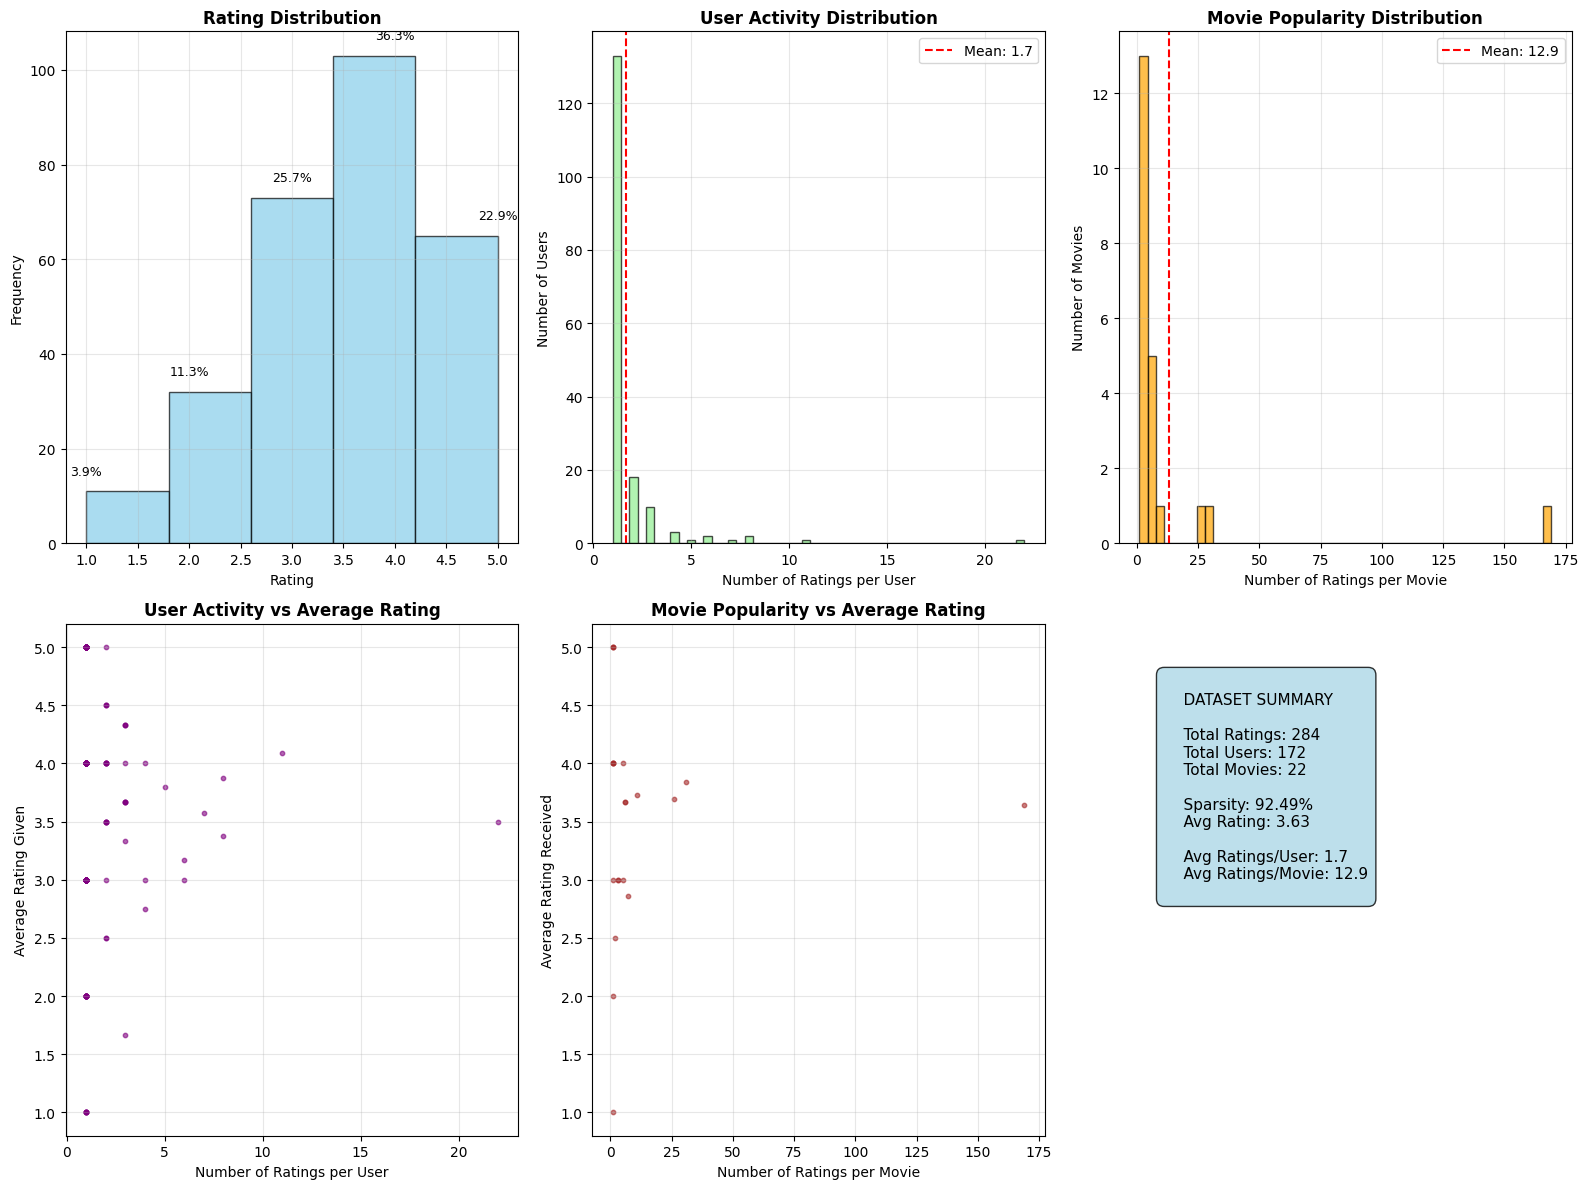

In [3]:
def plot_data_exploration(df, stats):
    """Create comprehensive visualization of the dataset"""

    fig = plt.figure(figsize=(16, 12))

    # 1. Rating Distribution
    plt.subplot(2, 3, 1)
    df['rating'].hist(bins=5, alpha=0.7, color='skyblue', edgecolor='black')
    plt.title('Rating Distribution', fontsize=12, fontweight='bold')
    plt.xlabel('Rating')
    plt.ylabel('Frequency')
    plt.grid(True, alpha=0.3)

    # Add percentages on bars
    rating_counts = df['rating'].value_counts().sort_index()
    for i, (rating, count) in enumerate(rating_counts.items()):
        percentage = (count / len(df)) * 100
        plt.text(rating, count + len(df)*0.01, f'{percentage:.1f}%',
                ha='center', va='bottom', fontsize=9)

    # 2. User Activity Distribution
    plt.subplot(2, 3, 2)
    user_activity = stats['user_activity']
    user_activity.hist(bins=50, alpha=0.7, color='lightgreen', edgecolor='black')
    plt.title('User Activity Distribution', fontsize=12, fontweight='bold')
    plt.xlabel('Number of Ratings per User')
    plt.ylabel('Number of Users')
    plt.grid(True, alpha=0.3)
    plt.axvline(user_activity.mean(), color='red', linestyle='--',
                label=f'Mean: {user_activity.mean():.1f}')
    plt.legend()

    # 3. Movie Popularity Distribution
    plt.subplot(2, 3, 3)
    movie_popularity = stats['movie_popularity']
    movie_popularity.hist(bins=50, alpha=0.7, color='orange', edgecolor='black')
    plt.title('Movie Popularity Distribution', fontsize=12, fontweight='bold')
    plt.xlabel('Number of Ratings per Movie')
    plt.ylabel('Number of Movies')
    plt.grid(True, alpha=0.3)
    plt.axvline(movie_popularity.mean(), color='red', linestyle='--',
                label=f'Mean: {movie_popularity.mean():.1f}')
    plt.legend()

    # 4. Rating vs User Activity
    plt.subplot(2, 3, 4)
    user_avg_rating = df.groupby('userId')['rating'].mean()
    plt.scatter(user_activity, user_avg_rating, alpha=0.6, s=10, color='purple')
    plt.title('User Activity vs Average Rating', fontsize=12, fontweight='bold')
    plt.xlabel('Number of Ratings per User')
    plt.ylabel('Average Rating Given')
    plt.grid(True, alpha=0.3)

    # 5. Rating vs Movie Popularity
    plt.subplot(2, 3, 5)
    movie_avg_rating = df.groupby('movieId')['rating'].mean()
    plt.scatter(movie_popularity, movie_avg_rating, alpha=0.6, s=10, color='brown')
    plt.title('Movie Popularity vs Average Rating', fontsize=12, fontweight='bold')
    plt.xlabel('Number of Ratings per Movie')
    plt.ylabel('Average Rating Received')
    plt.grid(True, alpha=0.3)

    # 6. Dataset Statistics Summary
    plt.subplot(2, 3, 6)
    plt.axis('off')
    summary_text = f"""
    DATASET SUMMARY

    Total Ratings: {stats['n_ratings']:,}
    Total Users: {stats['n_users']:,}
    Total Movies: {stats['n_movies']:,}

    Sparsity: {stats['sparsity']*100:.2f}%
    Avg Rating: {stats['avg_rating']:.2f}

    Avg Ratings/User: {stats['user_activity'].mean():.1f}
    Avg Ratings/Movie: {stats['movie_popularity'].mean():.1f}
    """
    plt.text(0.1, 0.9, summary_text, fontsize=11, verticalalignment='top',
             bbox=dict(boxstyle="round,pad=0.5", facecolor="lightblue", alpha=0.8))

    plt.tight_layout()
    plt.show()

# Calculate data statistics
n_ratings = len(movielens_data)
n_users = movielens_data['userId'].nunique()
n_movies = movielens_data['movieId'].nunique()
avg_rating = movielens_data['rating'].mean()
user_activity = movielens_data.groupby('userId').size()
movie_popularity = movielens_data.groupby('movieId').size()

# Calculate sparsity
# Sparsity = 1 - (Number of ratings / (Number of users * Number of movies))
sparsity = 1 - (n_ratings / (n_users * n_movies))

stats = {
    'n_ratings': n_ratings,
    'n_users': n_users,
    'n_movies': n_movies,
    'avg_rating': avg_rating,
    'user_activity': user_activity,
    'movie_popularity': movie_popularity,
    'sparsity': sparsity
}

print("\n" + "="*60)
print("DATASET STATISTICS")
print("="*60)
for key, value in stats.items():
    if isinstance(value, (int, float)):
        if key == 'sparsity':
            print(f"- {key.replace('_', ' ').title()}: {value*100:.2f}%")
        elif key in ['n_ratings', 'n_users', 'n_movies']:
             print(f"- {key.replace('_', ' ').title()}: {value:,}")
        else:
            print(f"- {key.replace('_', ' ').title()}: {value:.2f}")
    else:
         print(f"- {key.replace('_', ' ').title()}: Calculated (e.g., distributions)")


# Create visualizations
plot_data_exploration(movielens_data, stats)

In [4]:
# Calculate data statistics
n_ratings = len(movielens_data)
n_users = movielens_data['userId'].nunique()
n_movies = movielens_data['movieId'].nunique()
avg_rating = movielens_data['rating'].mean()
user_activity = movielens_data.groupby('userId').size()
movie_popularity = movielens_data.groupby('movieId').size()

# Calculate sparsity
# Sparsity = 1 - (Number of ratings / (Number of users * Number of movies))
sparsity = 1 - (n_ratings / (n_users * n_movies))

stats = {
    'n_ratings': n_ratings,
    'n_users': n_users,
    'n_movies': n_movies,
    'avg_rating': avg_rating,
    'user_activity': user_activity,
    'movie_popularity': movie_popularity,
    'sparsity': sparsity
}

print("\n" + "="*60)
print("DATASET STATISTICS")
print("="*60)
for key, value in stats.items():
    if isinstance(value, (int, float)):
        if key == 'sparsity':
            print(f"- {key.replace('_', ' ').title()}: {value*100:.2f}%")
        elif key in ['n_ratings', 'n_users', 'n_movies']:
             print(f"- {key.replace('_', ' ').title()}: {value:,}")
        else:
            print(f"- {key.replace('_', ' ').title()}: {value:.2f}")
    else:
         print(f"- {key.replace('_', ' ').title()}: Calculated (e.g., distributions)")


DATASET STATISTICS
- N Ratings: 284
- N Users: 172
- N Movies: 22
- Avg Rating: 3.63
- User Activity: Calculated (e.g., distributions)
- Movie Popularity: Calculated (e.g., distributions)
- Sparsity: 92.49%


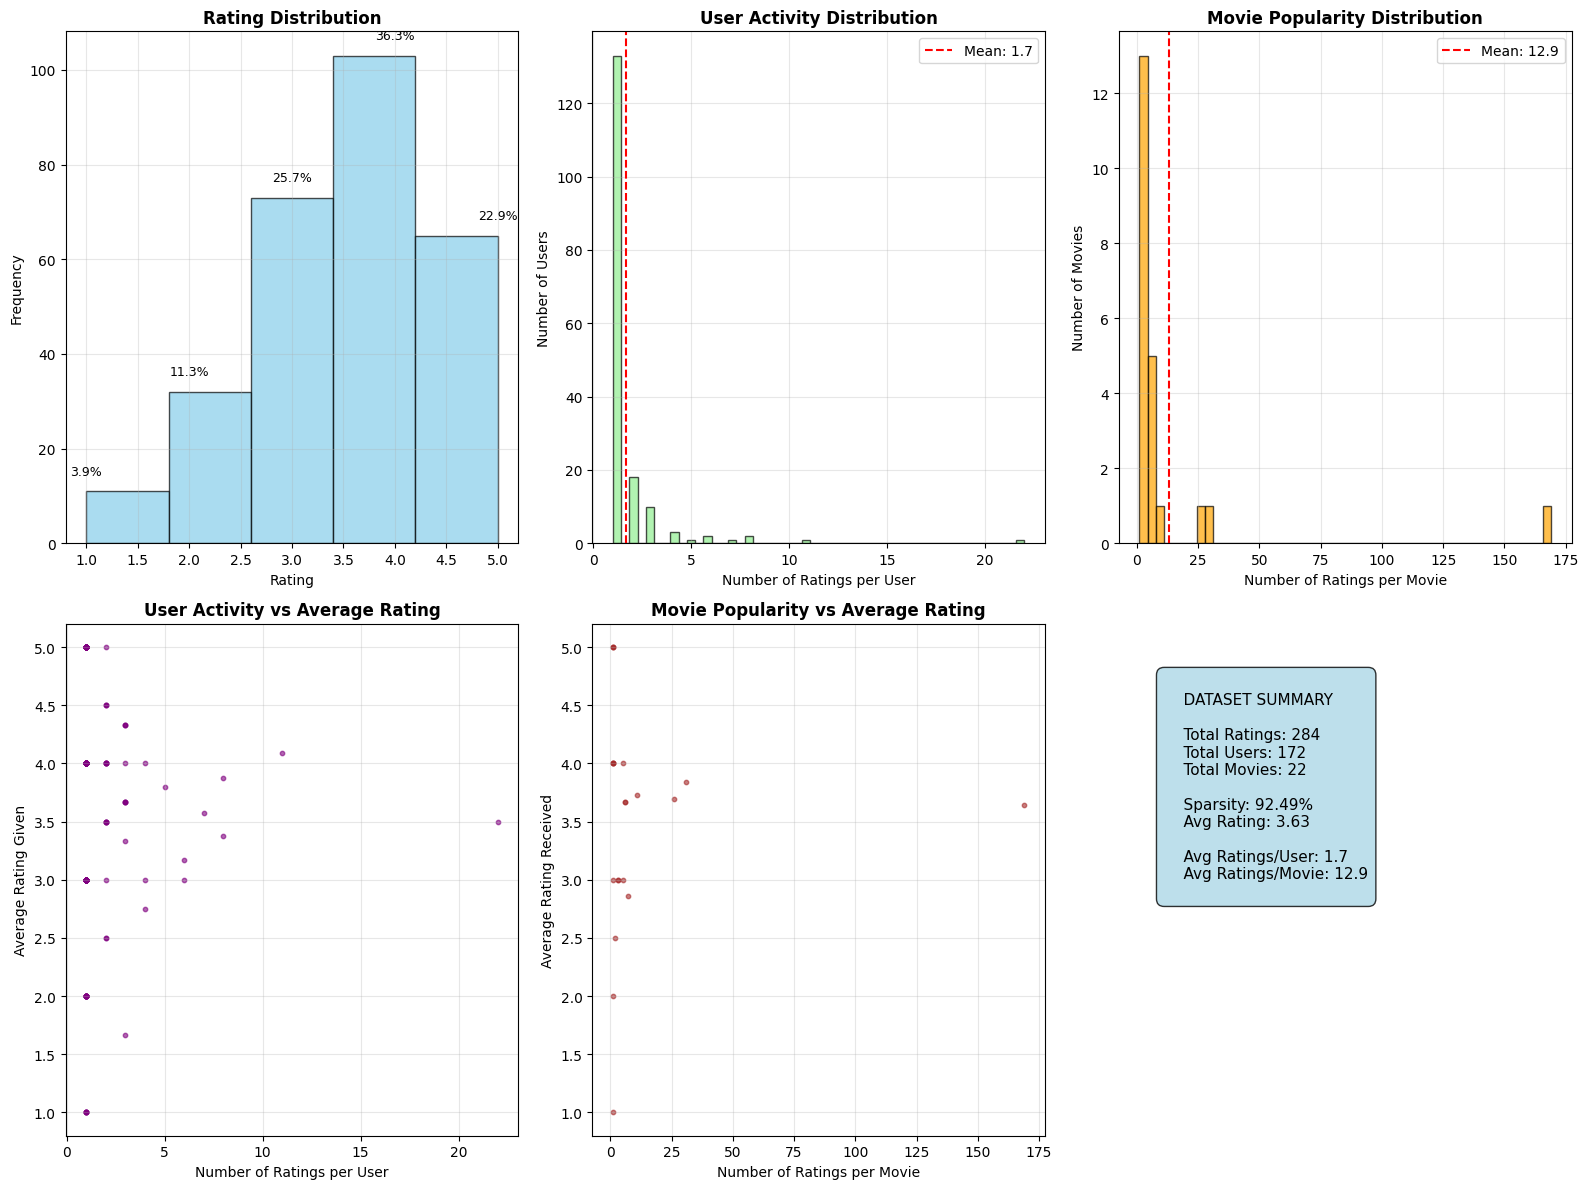

In [5]:
# Create visualizations
plot_data_exploration(movielens_data, stats)

In [6]:
class MovieLensDataProcessor:
    """Advanced processor untuk dataset MovieLens"""

    def __init__(self):
        self.user_encoder = {}
        self.item_encoder = {}
        self.user_decoder = {}
        self.item_decoder = {}
        self.original_user_ids = None
        self.original_movie_ids = None
        self.n_users = 0
        self.n_movies = 0
        self.min_rating = 0
        self.max_rating = 0

    def preprocess_data(self, df, min_user_ratings=5, min_movie_ratings=5):
        """
        Comprehensive data preprocessing

        Parameters:
        - df: Input DataFrame
        - min_user_ratings: Minimum ratings per user to keep
        - min_movie_ratings: Minimum ratings per movie to keep
        """
        print(f"\n PREPROCESSING DATA")
        print("=" * 40)

        original_shape = df.shape
        print(f"Original dataset: {original_shape[0]:,} ratings")

        # 1. Remove users and movies with too few ratings
        print(f"\n Filtering sparse users and movies...")

        # Filter users
        user_counts = df['userId'].value_counts()
        valid_users = user_counts[user_counts >= min_user_ratings].index
        df_filtered = df[df['userId'].isin(valid_users)]

        print(f"Users after filtering (min {min_user_ratings} ratings): {len(valid_users):,}")

        # Filter movies
        movie_counts = df_filtered['movieId'].value_counts()
        valid_movies = movie_counts[movie_counts >= min_movie_ratings].index
        df_filtered = df_filtered[df_filtered['movieId'].isin(valid_movies)]

        print(f"Movies after filtering (min {min_movie_ratings} ratings): {len(valid_movies):,}")
        print(f"Ratings after filtering: {len(df_filtered):,}")

        # 2. Encode user and movie IDs to continuous integers
        print(f"\n Encoding user and movie IDs...")

        unique_users = sorted(df_filtered['userId'].unique())
        unique_movies = sorted(df_filtered['movieId'].unique())

        self.user_encoder = {user: idx for idx, user in enumerate(unique_users)}
        self.item_encoder = {movie: idx for idx, movie in enumerate(unique_movies)}
        self.user_decoder = {idx: user for user, idx in self.user_encoder.items()}
        self.item_decoder = {idx: movie for movie, idx in self.item_encoder.items()}

        # Apply encoding
        df_filtered = df_filtered.copy()
        df_filtered['user_encoded'] = df_filtered['userId'].map(self.user_encoder)
        df_filtered['movie_encoded'] = df_filtered['movieId'].map(self.item_encoder)

        # 3. Normalize ratings to [0, 1] for neural network
        self.min_rating = df_filtered['rating'].min()
        self.max_rating = df_filtered['rating'].max()
        df_filtered['rating_normalized'] = (df_filtered['rating'] - self.min_rating) / (self.max_rating - self.min_rating)

        # Store metadata
        self.n_users = len(unique_users)
        self.n_movies = len(unique_movies)
        self.original_user_ids = unique_users
        self.original_movie_ids = unique_movies

        # 4. Final statistics
        sparsity = 1 - (len(df_filtered) / (self.n_users * self.n_movies))

        print(f"\n PREPROCESSING COMPLETED:")
        print(f"   Final users: {self.n_users:,}")
        print(f"   Final movies: {self.n_movies:,}")
        print(f"   Final ratings: {len(df_filtered):,}")
        print(f"   Final sparsity: {sparsity * 100:.2f}%")
        print(f"   Rating range: [{self.min_rating}, {self.max_rating}]")

        return df_filtered

    def create_negative_samples(self, df, neg_ratio=1.0, method='random'):
        """
        Create negative samples for implicit feedback learning

        Parameters:
        - df: Preprocessed DataFrame
        - neg_ratio: Ratio of negative to positive samples
        - method: 'random' or 'popular' sampling
        """
        print(f"\n CREATING NEGATIVE SAMPLES")
        print("=" * 40)
        print(f"Method: {method}")
        print(f"Negative ratio: {neg_ratio}")

        # Get all positive interactions
        positive_interactions = set(zip(df['user_encoded'], df['movie_encoded']))
        negative_samples = []

        # Get movie popularity for popular negative sampling
        if method == 'popular':
            movie_popularity = df['movie_encoded'].value_counts()
            popular_movies = movie_popularity.head(int(len(movie_popularity) * 0.2)).index.tolist()

        # Generate negative samples for each user
        for user in range(self.n_users):
            user_items = df[df['user_encoded'] == user]['movie_encoded'].values
            n_pos = len(user_items)
            n_neg = max(1, int(n_pos * neg_ratio))

            neg_items = []
            attempts = 0
            max_attempts = n_neg * 10

            while len(neg_items) < n_neg and attempts < max_attempts:
                if method == 'random':
                    item = np.random.randint(0, self.n_movies)
                elif method == 'popular':
                    item = np.random.choice(popular_movies)

                if (user, item) not in positive_interactions and item not in neg_items:
                    neg_items.append(item)

                attempts += 1

            # Add negative samples
            for item in neg_items:
                negative_samples.append({
                    'userId': self.user_decoder[user],
                    'movieId': self.item_decoder[item],
                    'rating': self.min_rating,  # Lowest rating for negative
                    'user_encoded': user,
                    'movie_encoded': item,
                    'rating_normalized': 0.0  # 0 for negative samples
                })

        # Combine positive and negative samples
        neg_df = pd.DataFrame(negative_samples)

        # Add explicit labels for positive/negative
        df_pos = df.copy()
        df_pos['label'] = 1  # Positive
        neg_df['label'] = 0  # Negative

        combined_df = pd.concat([df_pos, neg_df], ignore_index=True)

        # Shuffle the data
        combined_df = combined_df.sample(frac=1, random_state=42).reset_index(drop=True)

        print(f" Negative sampling completed:")
        print(f"   Positive samples: {len(df):,}")
        print(f"   Negative samples: {len(neg_df):,}")
        print(f"   Total samples: {len(combined_df):,}")
        print(f"   Positive ratio: {len(df)/len(combined_df)*100:.1f}%")

        return combined_df

    def denormalize_rating(self, normalized_rating):
        """Convert normalized rating back to original scale"""
        return normalized_rating * (self.max_rating - self.min_rating) + self.min_rating

print(" Data Processor class defined!")

 Data Processor class defined!


In [7]:
print("\n" + "="*60)
print(" EXECUTING DATA PREPROCESSING")
print("="*60)

# Initialize processor
processor = MovieLensDataProcessor()

# Preprocess data
df_processed = processor.preprocess_data(
    movielens_data,
    min_user_ratings=1,  # Keep users with at least 1 rating
    min_movie_ratings=1   # Keep movies with at least 1 rating
)

# Display processed data info
print(f"\n Processed Data Sample:")
print(df_processed[['userId', 'movieId', 'rating', 'user_encoded', 'movie_encoded', 'rating_normalized']].head(10))

# Create negative samples
df_with_negatives = processor.create_negative_samples(
    df_processed,
    neg_ratio=0.5,  # 0.5 negative samples per positive
    method='random'
)

# Display final data info
print(f"\n Final Dataset Info:")
print(f"Shape: {df_with_negatives.shape}")
print(f"Columns: {list(df_with_negatives.columns)}")
print("\nLabel distribution:")
print(df_with_negatives['label'].value_counts())


 EXECUTING DATA PREPROCESSING

 PREPROCESSING DATA
Original dataset: 284 ratings

 Filtering sparse users and movies...
Users after filtering (min 1 ratings): 172
Movies after filtering (min 1 ratings): 22
Ratings after filtering: 284

 Encoding user and movie IDs...

 PREPROCESSING COMPLETED:
   Final users: 172
   Final movies: 22
   Final ratings: 284
   Final sparsity: 92.49%
   Rating range: [1, 5]

 Processed Data Sample:
    userId  movieId  rating  user_encoded  movie_encoded  rating_normalized
0      565     1441       5           103             19               1.00
14     405     1441       4            65             19               0.75
17     665     1441       5           119             19               1.00
19     565      424       4           103              4               0.75
26     897     1441       4           163             19               0.75
35     565     1404       3           103             18               0.50
37     613     1441       2        

In [8]:
class MatrixFactorization:
    """
    Matrix Factorization using Stochastic Gradient Descent
    Baseline model untuk comparison dengan Neural CF
    """

    def __init__(self, n_users, n_items, n_factors=50, learning_rate=0.01,
                 reg_lambda=0.01, reg_bias=0.01):
        self.n_users = n_users
        self.n_items = n_items
        self.n_factors = n_factors
        self.learning_rate = learning_rate
        self.reg_lambda = reg_lambda
        self.reg_bias = reg_bias

        # Initialize latent factors dengan Xavier initialization
        limit = np.sqrt(6.0 / (n_users + n_items + n_factors))
        self.user_factors = np.random.uniform(-limit, limit, (n_users, n_factors))
        self.item_factors = np.random.uniform(-limit, limit, (n_items, n_factors))

        # Initialize biases
        self.user_bias = np.zeros(n_users)
        self.item_bias = np.zeros(n_items)
        self.global_bias = 0.0

        # Training history
        self.history = {'train_rmse': [], 'train_mae': []}

    def predict(self, user, item):
        """Predict rating untuk user-item pair"""
        if user >= self.n_users or item >= self.n_items:
            return self.global_bias

        prediction = (self.global_bias +
                     self.user_bias[user] +
                     self.item_bias[item] +
                     np.dot(self.user_factors[user], self.item_factors[item]))
        return prediction

    def predict_batch(self, users, items):
        """Batch prediction untuk efficiency"""
        predictions = []
        for user, item in zip(users, items):
            predictions.append(self.predict(user, item))
        return np.array(predictions)

    def train(self, X_train, y_train, X_val=None, y_val=None, epochs=100, verbose=True):
        """
        Train Matrix Factorization model

        Parameters:
        - X_train: Training user-item pairs
        - y_train: Training ratings
        - X_val: Validation user-item pairs (optional)
        - y_val: Validation ratings (optional)
        - epochs: Number of training epochs
        - verbose: Print progress
        """

        self.global_bias = np.mean(y_train)

        print(f"\n Training Matrix Factorization:")
        print(f"   Factors: {self.n_factors}")
        print(f"   Learning rate: {self.learning_rate}")
        print(f"   Regularization: λ={self.reg_lambda}, λ_bias={self.reg_bias}")
        print(f"   Training samples: {len(X_train):,}")

        best_val_rmse = float('inf')
        patience = 10
        patience_counter = 0

        for epoch in range(epochs):
            # Shuffle training data
            indices = np.random.permutation(len(X_train))
            X_shuffled = X_train[indices]
            y_shuffled = y_train[indices]

            # Training step
            total_loss = 0
            for i, (user, item) in enumerate(X_shuffled):
                rating = y_shuffled[i]

                # Predict dan compute error
                pred = self.predict(user, item)
                error = rating - pred

                # Save current factors untuk update
                user_factors_old = self.user_factors[user].copy()
                item_factors_old = self.item_factors[item].copy()
                user_bias_old = self.user_bias[user]
                item_bias_old = self.item_bias[item]

                # Update parameters using SGD
                self.user_factors[user] += self.learning_rate * (
                    error * item_factors_old - self.reg_lambda * user_factors_old
                )
                self.item_factors[item] += self.learning_rate * (
                    error * user_factors_old - self.reg_lambda * item_factors_old
                )
                self.user_bias[user] += self.learning_rate * (
                    error - self.reg_bias * user_bias_old
                )
                self.item_bias[item] += self.learning_rate * (
                    error - self.reg_bias * item_bias_old
                )

                total_loss += error ** 2

            # Calculate metrics
            train_rmse = np.sqrt(total_loss / len(X_train))
            train_predictions = self.predict_batch(X_train[:, 0], X_train[:, 1])
            train_mae = np.mean(np.abs(y_train - train_predictions))

            self.history['train_rmse'].append(train_rmse)
            self.history['train_mae'].append(train_mae)

            # Validation metrics
            val_rmse = None
            if X_val is not None and y_val is not None:
                val_predictions = self.predict_batch(X_val[:, 0], X_val[:, 1])
                val_rmse = np.sqrt(np.mean((y_val - val_predictions) ** 2))

                # Early stopping
                if val_rmse < best_val_rmse:
                    best_val_rmse = val_rmse
                    patience_counter = 0
                else:
                    patience_counter += 1

                if patience_counter >= patience:
                    if verbose:
                        print(f"Early stopping at epoch {epoch}")
                    break

            # Print progress
            if verbose and (epoch % 20 == 0 or epoch == epochs - 1):
                val_str = f", Val RMSE: {val_rmse:.4f}" if val_rmse else ""
                print(f"Epoch {epoch:3d}: Train RMSE: {train_rmse:.4f}, Train MAE: {train_mae:.4f}{val_str}")

        print(" Matrix Factorization training completed!")

print(" Matrix Factorization class defined!")


 Matrix Factorization class defined!


In [9]:
class NeuralCollaborativeFiltering:
    """
    Neural Collaborative Filtering implementation
    Combines embeddings with deep neural networks
    """

    def __init__(self, n_users, n_items, embedding_dim=50, hidden_units=[128, 64, 32],
                 dropout_rate=0.3, l2_reg=1e-4, learning_rate=0.001):
        self.n_users = n_users
        self.n_items = n_items
        self.embedding_dim = embedding_dim
        self.hidden_units = hidden_units
        self.dropout_rate = dropout_rate
        self.l2_reg = l2_reg
        self.learning_rate = learning_rate
        self.model = None
        self.history = None

    def build_model(self):
        """Build Neural Collaborative Filtering architecture"""

        print(f"\n Building NCF Architecture:")
        print(f"   Users: {self.n_users:,}")
        print(f"   Items: {self.n_items:,}")
        print(f"   Embedding dim: {self.embedding_dim}")
        print(f"   Hidden units: {self.hidden_units}")
        print(f"   Dropout: {self.dropout_rate}")
        print(f"   L2 regularization: {self.l2_reg}")

        # Input layers
        user_input = layers.Input(shape=(), name='user_input', dtype='int32')
        item_input = layers.Input(shape=(), name='item_input', dtype='int32')

        # Embedding layers dengan L2 regularization
        user_embedding = layers.Embedding(
            input_dim=self.n_users,
            output_dim=self.embedding_dim,
            embeddings_initializer='he_normal',
            embeddings_regularizer=regularizers.l2(self.l2_reg),
            name='user_embedding'
        )(user_input)

        item_embedding = layers.Embedding(
            input_dim=self.n_items,
            output_dim=self.embedding_dim,
            embeddings_initializer='he_normal',
            embeddings_regularizer=regularizers.l2(self.l2_reg),
            name='item_embedding'
        )(item_input)

        # Flatten embeddings
        user_vec = layers.Flatten(name='user_flatten')(user_embedding)
        item_vec = layers.Flatten(name='item_flatten')(item_embedding)

        # Concatenate user dan item embeddings
        concat_layer = layers.Concatenate(name='concat')([user_vec, item_vec])

        # Add batch normalization
        x = layers.BatchNormalization(name='batch_norm_input')(concat_layer)

        # Multi-Layer Perceptron
        for i, units in enumerate(self.hidden_units):
            x = layers.Dense(
                units,
                activation='relu',
                kernel_initializer='he_normal',
                kernel_regularizer=regularizers.l2(self.l2_reg),
                name=f'dense_{i}'
            )(x)
            x = layers.BatchNormalization(name=f'batch_norm_{i}')(x)

In [10]:
# Calculate data statistics
n_ratings = len(movielens_data)
n_users = movielens_data['userId'].nunique()
n_movies = movielens_data['movieId'].nunique()
avg_rating = movielens_data['rating'].mean()
user_activity = movielens_data.groupby('userId').size()
movie_popularity = movielens_data.groupby('movieId').size()

# Calculate sparsity
# Sparsity = 1 - (Number of ratings / (Number of users * Number of movies))
sparsity = 1 - (n_ratings / (n_users * n_movies))

stats = {
    'n_ratings': n_ratings,
    'n_users': n_users,
    'n_movies': n_movies,
    'avg_rating': avg_rating,
    'user_activity': user_activity,
    'movie_popularity': movie_popularity,
    'sparsity': sparsity
}

print("\n" + "="*60)
print(" DATASET STATISTICS")
print("="*60)
for key, value in stats.items():
    if isinstance(value, (int, float)):
        if key == 'sparsity':
            print(f"- {key.replace('_', ' ').title()}: {value*100:.2f}%")
        elif key in ['n_ratings', 'n_users', 'n_movies']:
             print(f"- {key.replace('_', ' ').title()}: {value:,}")
        else:
            print(f"- {key.replace('_', ' ').title()}: {value:.2f}")
    else:
         print(f"- {key.replace('_', ' ').title()}: Calculated (e.g., distributions)")


 DATASET STATISTICS
- N Ratings: 284
- N Users: 172
- N Movies: 22
- Avg Rating: 3.63
- User Activity: Calculated (e.g., distributions)
- Movie Popularity: Calculated (e.g., distributions)
- Sparsity: 92.49%


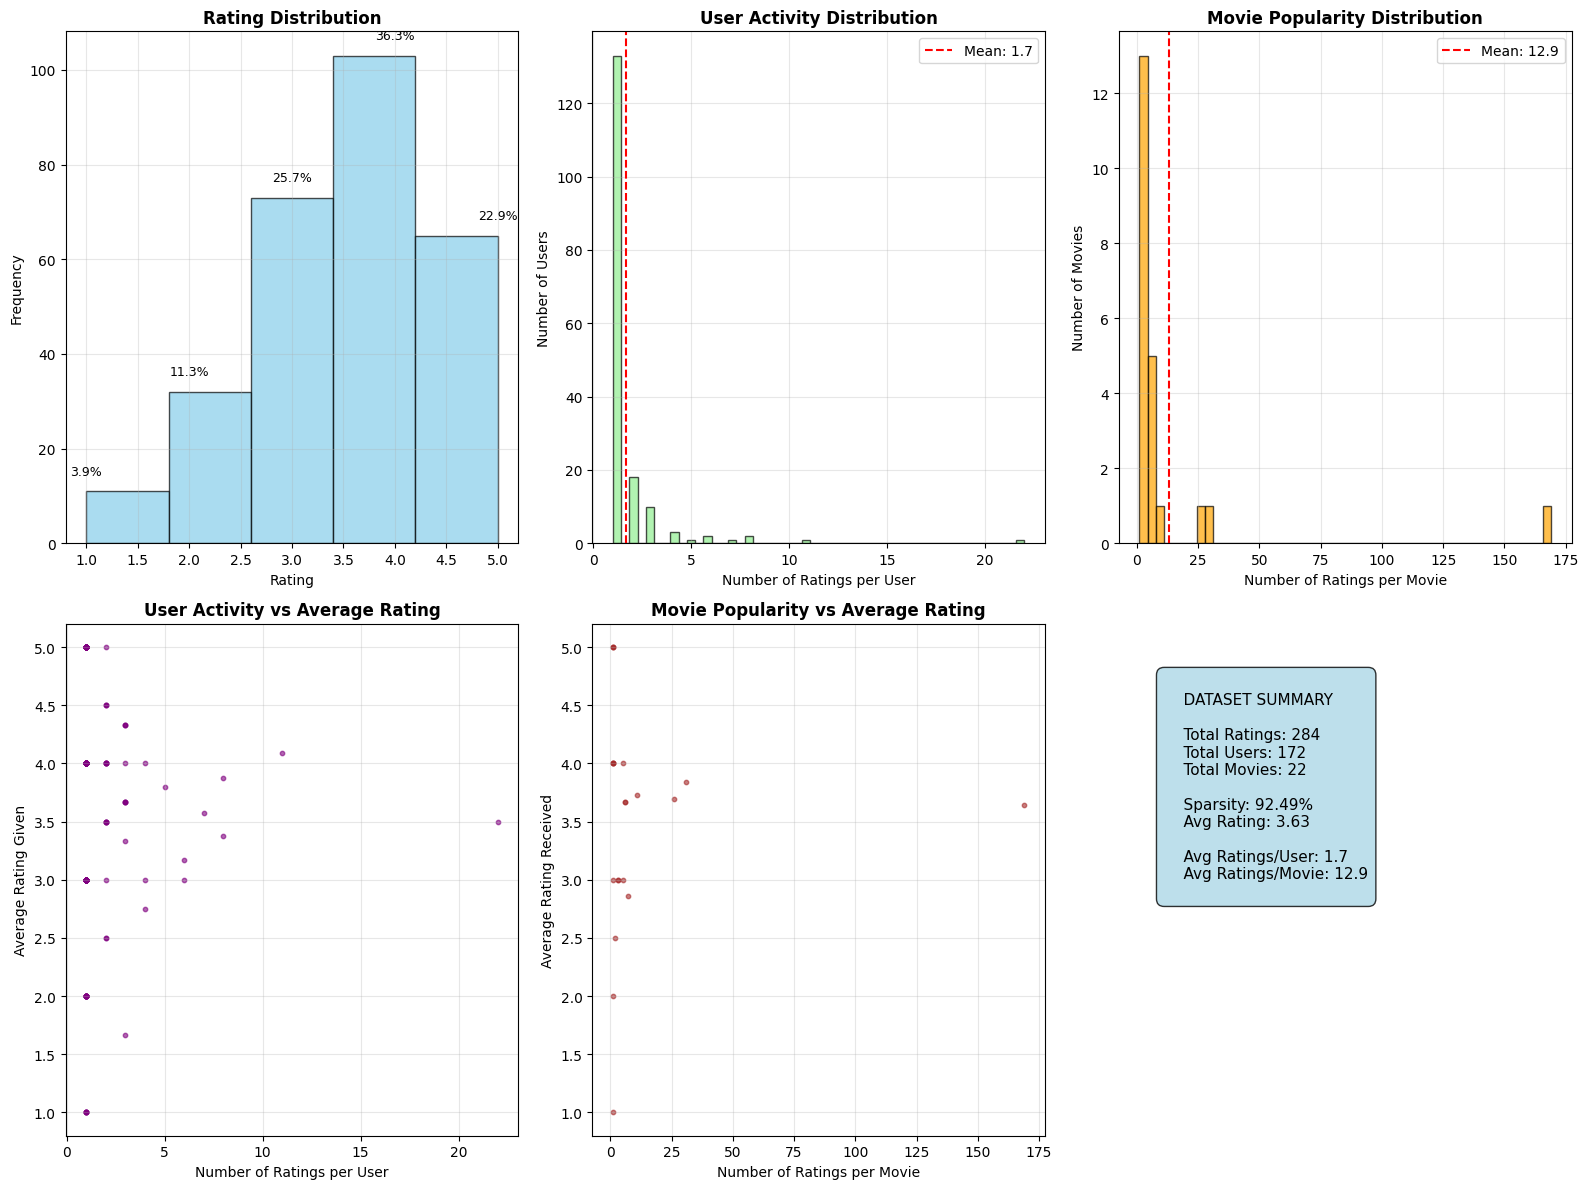

In [11]:
# Create visualizations
plot_data_exploration(movielens_data, stats)